# TP3: Detector de SPAM

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    RocCurveDisplay, ConfusionMatrixDisplay, 
    recall_score, precision_score, accuracy_score, f1_score, balanced_accuracy_score
)
from sklearn.pipeline import make_pipeline

sns.set_theme()

# Data

In [2]:
DATA_PATH = Path("./data")

df = pd.read_csv(DATA_PATH / "spambase.csv")
df

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,word_freq_edu,word_freq_table,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,spam
0,0,640,640,0,320,0,0,0,0,0,...,0,0,0,0,0,0,778,0,0,1
1,210,280,500,0,140,280,210,70,0,940,...,0,0,0,0,132,0,372,180,48,1
2,60,0,710,0,1230,190,190,120,640,250,...,60,0,0,10,143,0,276,184,10,1
3,0,0,0,0,630,0,310,630,310,630,...,0,0,0,0,137,0,137,0,0,1
4,0,0,0,0,630,0,310,630,310,630,...,0,0,0,0,135,0,135,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4596,310,0,620,0,0,310,0,0,0,0,...,310,0,0,0,232,0,0,0,0,0
4597,0,0,0,0,0,0,0,0,0,0,...,2000,0,0,0,0,0,353,0,0,0
4598,300,0,300,0,0,0,0,0,0,0,...,1200,0,0,102,718,0,0,0,0,0
4599,960,0,0,0,320,0,0,0,0,0,...,320,0,0,0,57,0,0,0,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4601 entries, 0 to 4600
Data columns (total 55 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   word_freq_make        4601 non-null   int64
 1   word_freq_address     4601 non-null   int64
 2   word_freq_all         4601 non-null   int64
 3   word_freq_3d          4601 non-null   int64
 4   word_freq_our         4601 non-null   int64
 5   word_freq_over        4601 non-null   int64
 6   word_freq_remove      4601 non-null   int64
 7   word_freq_internet    4601 non-null   int64
 8   word_freq_order       4601 non-null   int64
 9   word_freq_mail        4601 non-null   int64
 10  word_freq_receive     4601 non-null   int64
 11  word_freq_will        4601 non-null   int64
 12  word_freq_people      4601 non-null   int64
 13  word_freq_report      4601 non-null   int64
 14  word_freq_addresses   4601 non-null   int64
 15  word_freq_free        4601 non-null   int64
 16  word_f

# 1) Palabras más frecuentes por tipo de mail

In [4]:
aux = (
    df
    .groupby('spam')
    .sum()
    .T
    .reset_index()
    .rename(columns={'index':'var',0:'no spam',1:'spam'})
)

aux['term'] = aux['var'].apply(lambda x: x.split('_')[-1])
aux['kind'] = aux['var'].apply(lambda x: x.split('_')[0])
aux.columns.rename('', inplace=True)
aux.head()

,var,no spam,spam,term,kind
0,word_freq_make,204860,276190,make,word
1,word_freq_address,681569,298510,address,word
2,word_freq_all,559220,732080,all,word
3,word_freq_3d,2470,298550,3d,word
4,word_freq_our,504739,931799,our,word


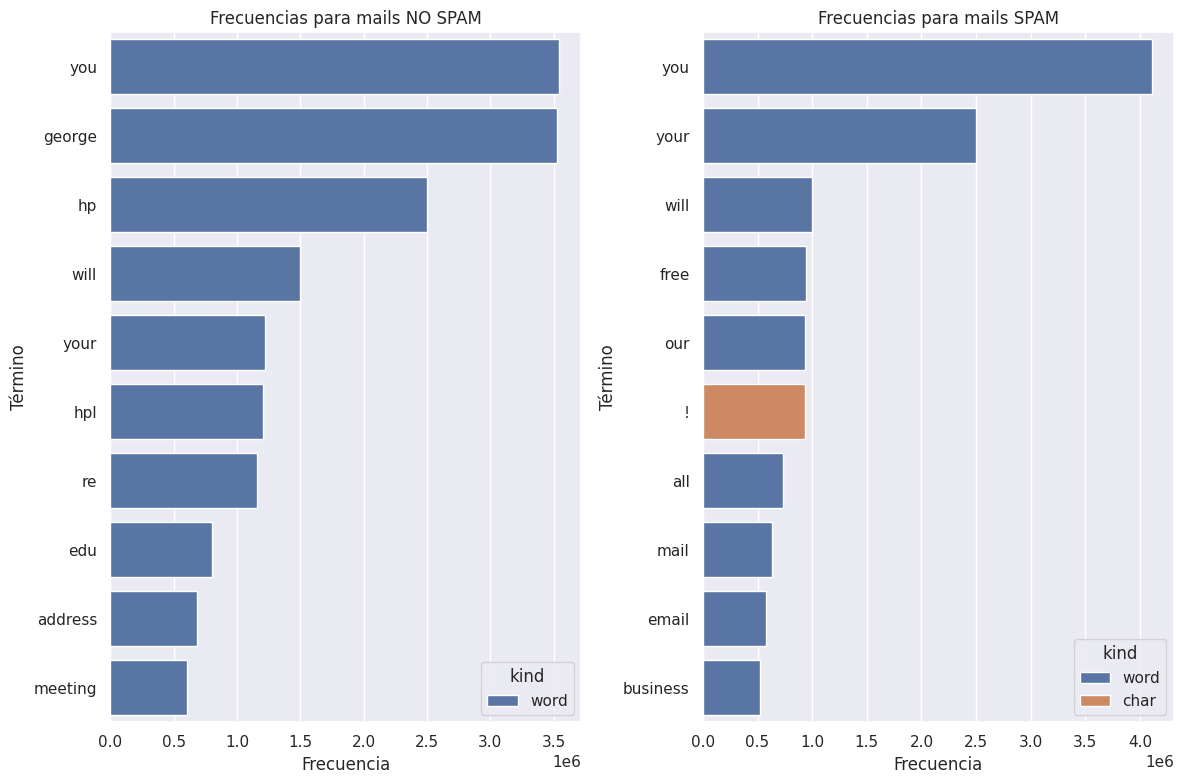

In [5]:
fig, axes = plt.subplots(ncols=2, figsize=(12,8))

for ax, lab, name in zip(axes, (0,1), ("no spam", "spam")):
    sns.barplot(
        aux.sort_values(name, ascending=False).head(10),
        y='term',
        x=name,
        orient='h',
        hue='kind',
        ax=ax
    )
    ax.set_xlabel('Frecuencia')
    ax.set_ylabel('Término')
    ax.set_title(f'Frecuencias para mails {name.upper()}')

plt.tight_layout()

Observando que en los mail SPAM aparece un término que no es una palabra, repetimos restringiendo a sólo palabras.

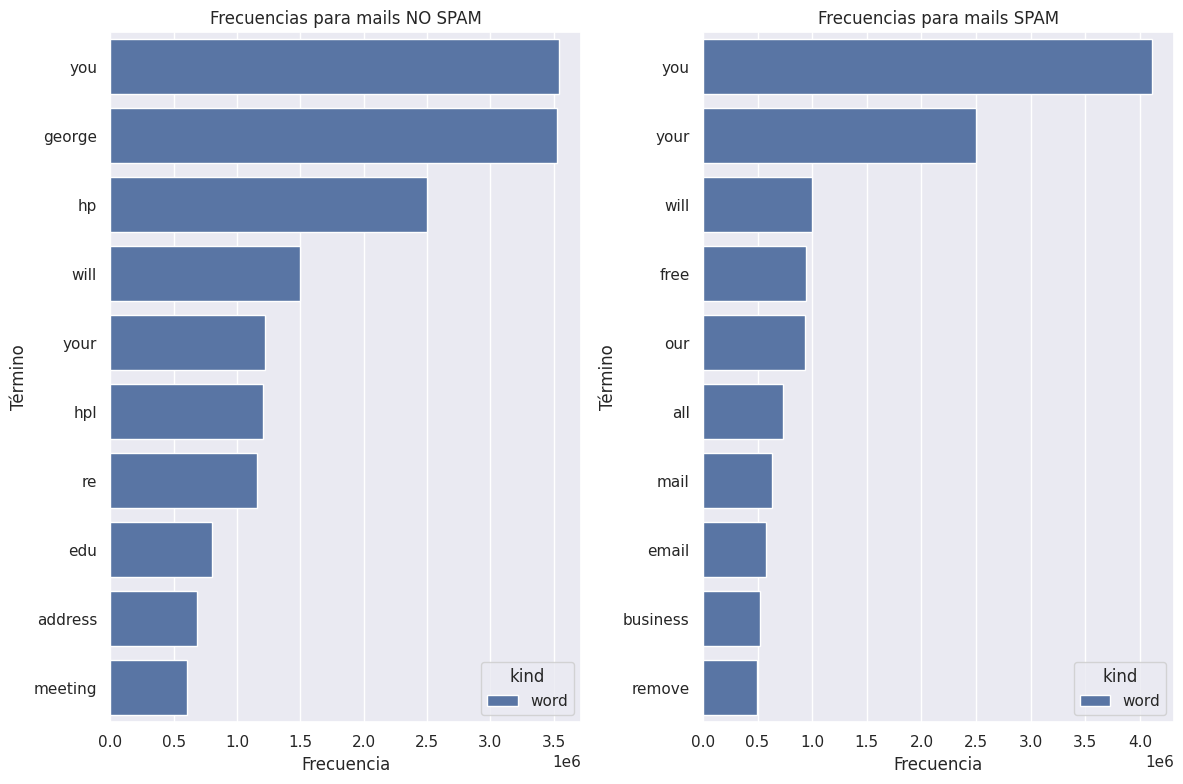

In [6]:
fig, axes = plt.subplots(ncols=2, figsize=(12,8))

for ax, lab, name in zip(axes, (0,1), ("no spam", "spam")):
    sns.barplot(
        aux[aux['kind']=='word'].sort_values(name, ascending=False).head(10),
        y='term',
        x=name,
        orient='h',
        hue='kind',
        ax=ax
    )
    ax.set_xlabel('Frecuencia')
    ax.set_ylabel('Término')
    ax.set_title(f'Frecuencias para mails {name.upper()}')

plt.tight_layout()

Por supuesto, cambia muy poco y sólo se observa que en vez de "!" aparece la palabra "remove".

* La distribución de palabras más frecuentes en los mails de SPAM es mucho más concentrada que en los NO SPAM.
* Algunas palabras que simplemente son muy comunes aparecen en ambos, como es el caso de "you", "your", "will".
* En los mails de SPAM llama la atención la frecuencia del símbolo "!" y referencias a correos como "mail" y "email".
* En los mails NO SPAM llama la atención la palabra "george", se asume que por alguna razón el dataset es de un subconjunto de correos que involucren a alguien que se llama así.

# 2) Separación train/test

In [7]:
X = df.drop(columns='spam')
y = df['spam']

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size=0.3, stratify=y)

# 3) Naïve Bayes

In [8]:
nb = MultinomialNB()

nb.fit(X_train, y_train)

y_pred_nb = nb.predict(X_test)

# 4) Logistic Regression

In [9]:
lr_pip = make_pipeline(StandardScaler(), LogisticRegression())

lr_pip.fit(X_train, y_train)

y_pred_lr = lr_pip.predict(X_test)

# 5) Comparación de matrices de confusión

In [10]:
MODEL_PREDS = {
    'Naive Bayes': y_pred_nb,
    'Logistic Regression': y_pred_lr,
}

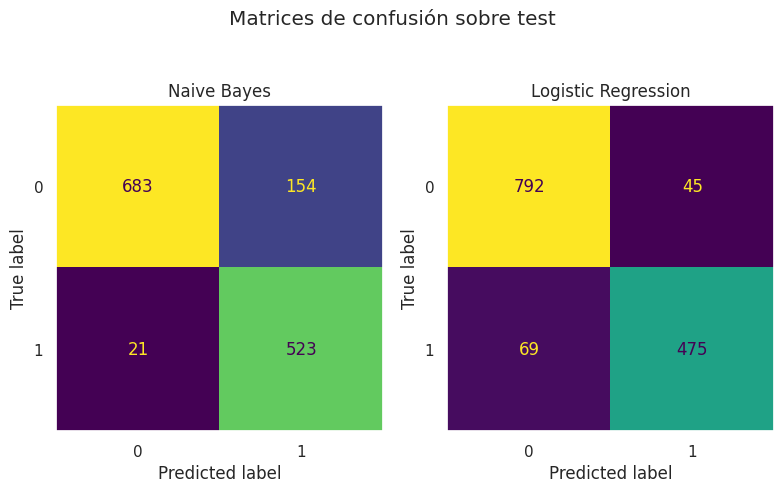

In [11]:
fig, axes = plt.subplots(ncols=2, figsize=(8,5))

for ax, (name, y_pred) in zip(axes, MODEL_PREDS.items()):
    cd = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, colorbar=False)
    ax.set_title(name)
    ax.grid(False)

fig.suptitle("Matrices de confusión sobre test")
plt.tight_layout()

* Naïve Bayes tiene mucho mejor recall, capturando 523 de los 544 casos de SPAM.
* La regresión logística por su parte tiene mucha mejor precisión, ya que los falsos positivos son menos del 10% de los verdaderos positivos vs. alrededor del 30% de NB.
* En resumen, NB comete más errores de tipo I mientras que LR comete más errores de tipo II.
* En el caso de detección de spam priorizamos los errores de tipo I, por lo que preferimos la regresión logística por sobre NB.

# 6) Cálculo de métricas

In [13]:
METRICS = {f.__name__.split("_")[0]:f for f in (recall_score, precision_score, accuracy_score, f1_score, balanced_accuracy_score)}

mm = []
for name, y_pred in MODEL_PREDS.items():
    aux = {'model': name}
    for f_name, f in METRICS.items():
        aux[f_name] = f(y_test, y_pred)
    mm.append(aux)

pd.DataFrame(mm).set_index('model')

,recall,precision,accuracy,f1,balanced
model,,,,,
Naive Bayes,0.961397,0.772526,0.873280,0.856675,0.888703
Logistic Regression,0.873162,0.913462,0.917451,0.892857,0.909699


Como se adelantó previamente a partir de una inspección visual de las matrices de confusión, NB tiene mejor recall mientras que LR tiene mejor precisión. En particular, LR tiene mucha mejor precisión que lo que tiene de mejor recall NB, lo cual queda evidenciado en que también la F1 es mejor en LR.

Respecto de las relaciones entre métricas y tipos de error, si $E1$ y $E2$ son la tasa de errores de cada tipo, $TP$ la cantidad de positivos correctamente detectados y $N$ la cantidad total de negativos en la muestra:
$$
Recall = 1 - E2
$$
y
$$
Precision = \frac{TP}{TP + E1 \cdot N}
$$

de donde se observa que la Precision es una función decreciente respecto de la tasa de error tipo I.

# 7) Curvas ROC y AUC

In [14]:
MODEL_PROBAS = {
    'Naive Bayes': nb.predict_proba(X_test)[:,1],
    'Logistic Regression': lr_pip.predict_proba(X_test)[:,1],
}

Para facilitar la comparación, graficamos ambas sobre el mismo plano. Observar que el gráfico informa también el área bajo la curva (AUC).

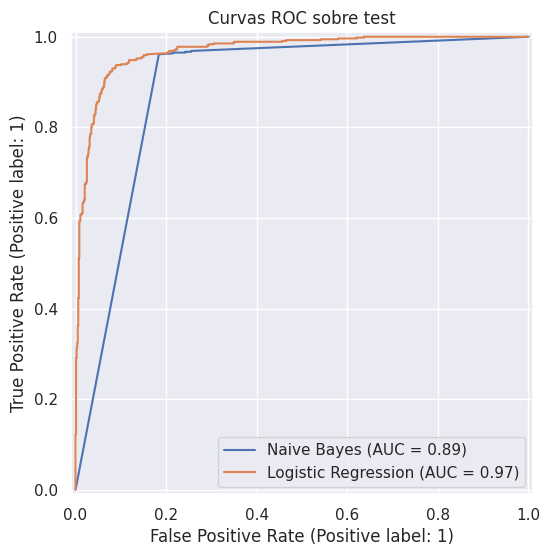

In [15]:
fig, ax = plt.subplots(figsize=(6,6))

for name, y_pred in MODEL_PROBAS.items():
    RocCurveDisplay.from_predictions(y_test, y_pred, ax=ax, name=name)

ax.set_title("Curvas ROC sobre test")
plt.show()

Nuevamente, vemos que la regresión logística domina al Naïve Bayes.